# BÁO CÁO DỰ ÁN KHAI PHÁ DỮ LIỆU: DỰ ĐOÁN GIÁ NHÀ (HOUSE PRICES)

## 1. Business Understanding (Hiểu nghiệp vụ)
- **Mục tiêu:** Xây dựng mô hình máy học để dự đoán giá nhà (SalePrice) dựa trên các đặc trưng như diện tích, số phòng, năm xây dựng...
- **Loại bài toán:** Hồi quy (Regression).
- **Đánh giá:** Sử dụng các chỉ số MAE, RMSE và R-squared.

In [3]:
%reload_ext autoreload
%autoreload 2
import pandas as pd
import matplotlib.pyplot as plt
import sys
import os

# Them duong dan thu muc src vao he thong de import modules
# (Di nguoc ra thu muc cha '..', sau do vao 'src')
current_dir = os.getcwd()
src_dir = os.path.join(current_dir, '..', 'src')

if src_dir not in sys.path:
    sys.path.insert(0, src_dir)

# Import cac module tu src (Code cua chung ta)
from preprocessing import HousePricePreprocessor
from modeling import ModelEvaluator, ModelFactory

print("Da thiet lap duong dan va import module thanh cong!")

Da thiet lap duong dan va import module thanh cong!


## 2. Data Understanding & 3. Data Preparation
Sử dụng module `preprocessing` để:
- Đọc dữ liệu và thống kê cơ bản.
- Xử lý giá trị thiếu (Imputation).
- Chia tập Train/Test (80/20).
- Chuẩn hóa dữ liệu (Scaling) cho mô hình tuyến tính.

In [4]:
# --- CELL 2: KHỞI TẠO VÀ XỬ LÝ DỮ LIỆU ---
import os

# 1. Xác định đường dẫn tuyệt đối tới file CSV
# Lấy thư mục hiện tại (notebooks)
nb_dir = os.getcwd()
# Đi ngược ra thư mục cha (..), vào folder data, trỏ tới file csv
data_path = os.path.abspath(os.path.join(nb_dir, '..', 'data', 'House_Prices.csv'))

print(f"📍 Đường dẫn dữ liệu: {data_path}")

# Kiểm tra xem file có thật sự ở đó không
if not os.path.exists(data_path):
    print("❌ LỖI: Máy tính vẫn không tìm thấy file. Hãy kiểm tra lại tên thư mục!")
else:
    print("✅ Đã tìm thấy file! Đang nạp...")

    # 2. Truyền đường dẫn này vào Class (Ghi đè đường dẫn mặc định)
    # Lúc này class sẽ dùng đúng đường dẫn này để gọi load_data
    prep = HousePricePreprocessor(data_path=data_path)

    # 3. Giờ thì gọi hàm thoải mái
    print("\n--- Thống kê dữ liệu ---")
    prep.explore_data()  # Hàm này sẽ tự gọi load_data() thành công

    # Các bước tiếp theo...
    X, y = prep.prepare_features()
    X_train, X_test, y_train, y_test = prep.split_data(X, y)
    X_train_scaled, X_test_scaled = prep.scale_features(X_train, X_test)

📍 Đường dẫn dữ liệu: c:\Tailieu\Nam4\Data Mining\data_mining\data\House_Prices.csv
✅ Đã tìm thấy file! Đang nạp...

--- Thống kê dữ liệu ---
Kich thuoc: (1460, 81)
Missing values: 7829
Du lieu trung lap: 0
Gia trung binh: $180,921
Features shape: (1460, 8)
Train set: (1168, 8)
Test set: (292, 8)


## 4. Modeling (Mô hình hóa)
Thực hiện huấn luyện 2 mô hình để so sánh:
1. **Linear Regression:** Mô hình cơ bản, dễ giải thích.
2. **Random Forest:** Mô hình phi tuyến, thường cho độ chính xác cao hơn.

In [5]:
# 2. HUAN LUYEN VA DANH GIA MO HINH

# Khoi tao bo danh gia va nha may tao mo hinh
evaluator = ModelEvaluator()
models = ModelFactory.create_models()

# --- Model 1: Linear Regression ---
# Luu y: Linear Regression can du lieu da chuan hoa (scaled) de toi uu
print("\n--- Danh gia Linear Regression ---")
lr_result = evaluator.evaluate_model(
    models['Linear Regression'], 
    X_train_scaled, X_test_scaled, y_train, y_test, 
    "Linear Regression"
)

# --- Model 2: Random Forest ---
# Luu y: Random Forest chay tot tren du lieu goc (khong can scale)
print("\n--- Danh gia Random Forest ---")
rf_result = evaluator.evaluate_model(
    models['Random Forest'], 
    X_train, X_test, y_train, y_test, 
    "Random Forest"
)


--- Danh gia Linear Regression ---

--- Danh gia mo hinh: Linear Regression ---
MAE  (Sai so tuyet doi): $25,124
RMSE (Sai so binh phuong): $39,608
R2   (Do chinh xac): 0.795

--- Danh gia Random Forest ---

--- Danh gia mo hinh: Random Forest ---
MAE  (Sai so tuyet doi): $19,045
RMSE (Sai so binh phuong): $28,871
R2   (Do chinh xac): 0.891


## 5. Evaluation (Đánh giá) & 6. Deployment (Triển khai)
- So sánh hiệu suất giữa hai mô hình dựa trên tập kiểm thử (Test Set).
- Trực quan hóa kết quả bằng biểu đồ.
- Lưu mô hình tốt nhất (`.pkl`) để triển khai lên ứng dụng Web (Streamlit).


--- Bang so sanh hieu suat ---
               Model           MAE          RMSE        R²
0  Linear Regression  25123.511760  39608.483601  0.795467
1      Random Forest  19044.802755  28871.167749  0.891329


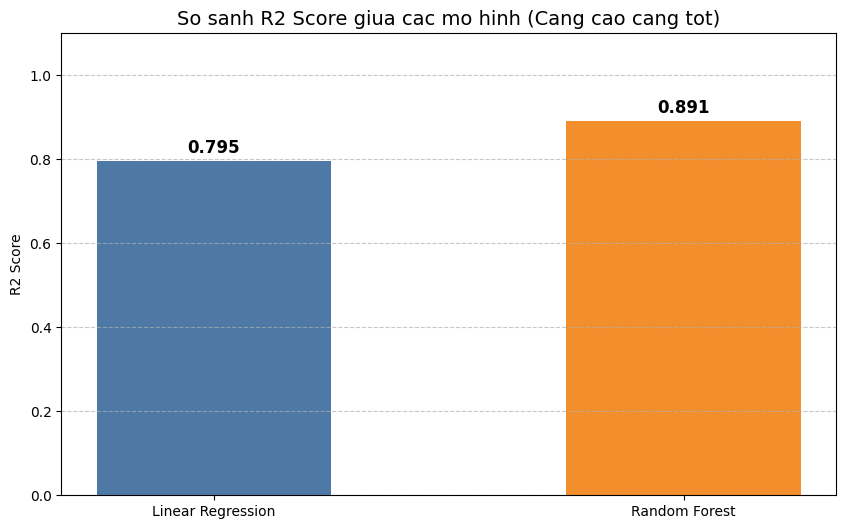

Ket luan: Random Forest tot hon Linear Regression khoang 9.6%


In [6]:
# 3. TONG KET VA TRUC QUAN HOA KET QUA

# Lay bang so sanh tu evaluator
results_df = evaluator.compare_models()

print("\n--- Bang so sanh hieu suat ---")
print(results_df)

# Ve bieu do cot so sanh R2 Score
plt.figure(figsize=(10, 6))

models_names = results_df['Model']
r2_scores = results_df['R²']

# Ve cot
plt.bar(models_names, r2_scores, color=['#4e79a7', '#f28e2b'], width=0.5)

# Trang tri bieu do
plt.title('So sanh R2 Score giua cac mo hinh (Cang cao cang tot)', fontsize=14)
plt.ylabel('R2 Score')
plt.ylim(0, 1.1) # Gioi han truc Y tu 0 den 1.1
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Hien thi gia tri cu the len dau cot
for i, v in enumerate(r2_scores):
    plt.text(i, v + 0.02, f"{v:.3f}", ha='center', fontweight='bold', fontsize=12)

plt.show()

# Ket luan
rf_score = rf_result['R²']
lr_score = lr_result['R²']
print(f"Ket luan: Random Forest tot hon Linear Regression khoang {(rf_score - lr_score)*100:.1f}%")